### Download Libraries

In [4]:
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
import seaborn as sns
from tqdm import trange


print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.enabled)

print("pyTorch Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Count:", torch.cuda.device_count())
    print("CUDA Current Device:", torch.cuda.current_device())
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
        

    print("pyTorch Version: ", torch.__version__)
    print("pyTorch CUDA Version: ", torch.version.cuda)
#torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(123)

2.1.2+cu121
12.1
True
pyTorch Available: True
CUDA Device Count: 1
CUDA Current Device: 0
CUDA Device Name: NVIDIA GeForce RTX 3070 Laptop GPU
pyTorch Version:  2.1.2+cu121
pyTorch CUDA Version:  12.1
cuda
123


### Generate Datasets: Spiral Dataset, Half Moon Dataset & SwissRoll Dataset

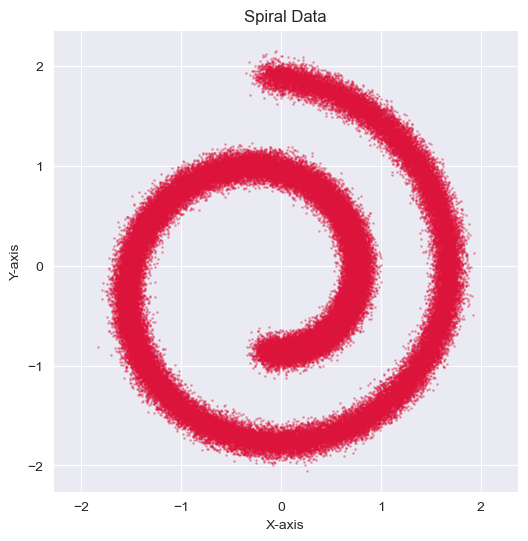

In [5]:
def generate_spiral_data(n_points=100000, noise_std=0.1):
    x, _ = make_swiss_roll(n_samples=100000, noise=0.5)
    x = x[:, [0, 2]]

    x = (x - x.mean()) / x.std()
    return torch.tensor(np.stack((x[:, 0], x[:, 1]), axis=-1), dtype=torch.float32)

spiral_data = generate_spiral_data()

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(spiral_data[:, 0], spiral_data[:, 1], s=1, color="crimson", alpha=0.3)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Spiral Data")
plt.axis("equal")
plt.show()

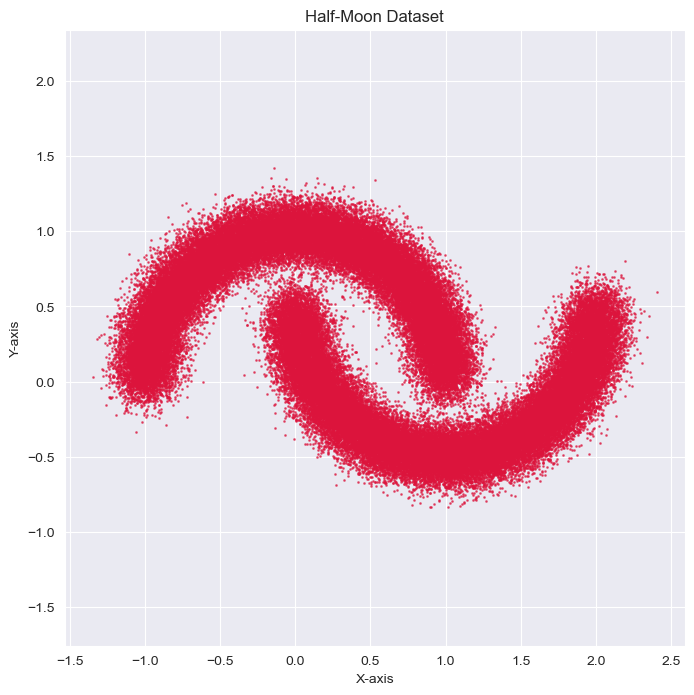

In [6]:
def generate_half_moon(n_samples=100000, noise=0.1):
    X,_= make_moons(n_samples=n_samples, noise=noise)
    return torch.tensor(np.stack((X[:, 0], X[:, 1]), axis=-1), dtype=torch.float32)

half_moon_data = generate_half_moon()

plt.figure(figsize=(8, 8))
plt.scatter(half_moon_data[:, 0], half_moon_data[:, 1], s=1, c="crimson", alpha=0.6)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Half-Moon Dataset")
plt.axis("equal")
plt.show()

In [4]:
# def generate_swiss_roll(n_samples=2000, noise=0.1):
#     X, t = make_swiss_roll(n_samples=n_samples, noise=noise)
#     return np.stack((X[:, 0], X[:, 1], X[:, 2]), axis=-1),t

# swiss_roll_dataset,t = generate_swiss_roll()

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(swiss_roll_dataset[:, 0], swiss_roll_dataset[:, 1], swiss_roll_dataset[:, 2], c=t, cmap="viridis", s=5)
# ax.set_xlabel("X-axis")
# ax.set_ylabel("Y-axis")
# ax.set_zlabel("Z-axis")
# ax.set_title("Swiss Roll Dataset")
# plt.show()
# print(t)

### Prepare Data for Learning

In [5]:
# tensor_spiral_data = torch.tensor(spiral_data, dtype=torch.float32)
# generated_half_moon_data = torch.tensor(half_moon_data, dtype=torch.float32)

### Diffusion Model Hyperparameters

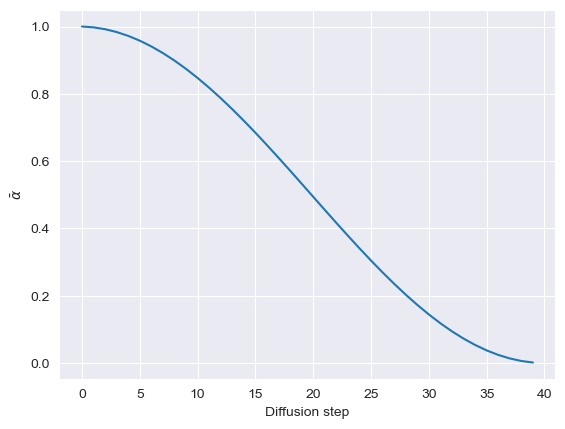

In [7]:
diffusion_steps = 40  # Number of steps in the diffusion process

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

In [8]:
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps

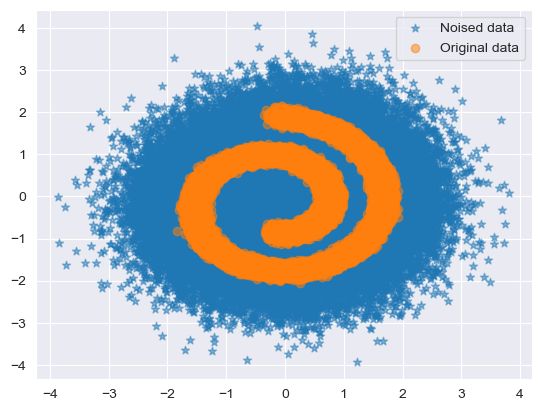

In [9]:
noiselevel = 20

noised_spiral_data, eps = noise(spiral_data, torch.full([len(spiral_data), 1], fill_value=noiselevel))
plt.scatter(noised_spiral_data[:, 0], noised_spiral_data[:, 1], marker="*", alpha=0.5)
plt.scatter(spiral_data[:, 0], spiral_data[:, 1], alpha=0.5)
plt.legend(["Noised data", "Original data"])
plt.show()

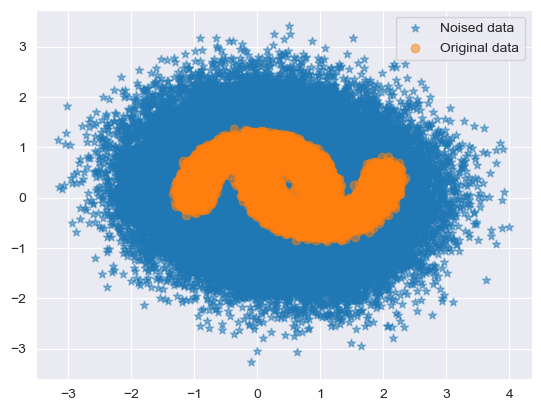

In [7]:
noiselevel = 20

noised_half_moon_data, eps = noise(half_moon_data, torch.full([len(half_moon_data), 1], fill_value=noiselevel))
plt.scatter(noised_half_moon_data[:, 0], noised_half_moon_data[:, 1], marker="*", alpha=0.5)
plt.scatter(half_moon_data[:, 0], half_moon_data[:, 1], alpha=0.5)
plt.legend(["Noised data", "Original data"])
plt.show()

### Diffusion Network

In [10]:
class DiffusionBlock(nn.Module):
    def __init__(self, hidden_layer, dropout_prob=0.1):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(hidden_layer, hidden_layer)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, hidden_layer = 64, dropout_prob=0.1):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, hidden_layer)
        self.midblocks = nn.ModuleList([DiffusionBlock(hidden_layer) for _ in range(nblocks)])
        self.dropout = nn.Dropout(dropout_prob)
        self.outblock = nn.Linear(hidden_layer, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.dropout(val)
        val = self.outblock(val)
        return val

### Training Diffusion Model Spiral Data

In [11]:
spiral_data_model = DiffusionModel(nfeatures=2, nblocks=4)

#device = "cuda"
spiral_data_model = spiral_data_model.to(device)

spiral_data_model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

In [12]:
epochs = 100
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(spiral_data_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=epochs)

for epoch in range(epochs):
    epoch_loss = steps = 0
    for i in range(0, len(spiral_data), batch_size):
        Xbatch = spiral_data[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = spiral_data_model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.8569117188453674
Epoch 10 loss = 0.5011221170425415
Epoch 20 loss = 0.48620039224624634
Epoch 30 loss = 0.4829411804676056
Epoch 40 loss = 0.474945992231369
Epoch 50 loss = 0.4734257161617279
Epoch 60 loss = 0.4676571190357208
Epoch 70 loss = 0.46242591738700867
Epoch 80 loss = 0.4647325575351715
Epoch 90 loss = 0.4664578139781952


In [13]:
def sample_ddpm(model, nsamples, nfeatures, mc_samples=30):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    model.train()
    samples = torch.zeros(mc_samples, nsamples, 2)
    with torch.no_grad():
        for i in range(mc_samples):
            x = torch.randn(size=(nsamples, nfeatures)).to(device)
            xt = [x]
            for t in range(diffusion_steps-1, 0, -1):
                predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
                # See DDPM paper between equations 11 and 12
                x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
                if t > 1:
                    # See DDPM paper section 3.2.
                    # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                    variance = betas[t]
                    std = variance ** (0.5)
                    x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
                xt += [x]
            samples[i] = x
    return x, xt, samples.mean(dim=0), samples.std(dim=0).norm(dim=1), samples

In [14]:
Xgen_spiral, Xgen_hist, mc_mean, mc_variance, samples = sample_ddpm(spiral_data_model, 10000, 2)
Xgen_spiral = Xgen_spiral.cpu()

plt.figure(figsize=(8, 8))
sns.kdeplot(x=mc_mean[:, 0].numpy(), y=mc_mean[:, 1].numpy(), weights=mc_variance.norm(dim=1).numpy(), cmap="coolwarm", fill=True)
plt.scatter(spiral_data[:, 0], spiral_data[:, 1], s=1, c="lightskyblue", alpha=0.5, label="Original Data")
plt.scatter(mc_mean[:, 0], mc_mean[:, 1], s=5, c="crimson", marker="1", alpha=0.6, label="Generated Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Spiral Dataset")
plt.axis("equal")
plt.legend()
plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

<Figure size 800x800 with 0 Axes>

In [15]:
Xgen_spiral, Xgen_hist, mc_mean, mc_variance, samples = sample_ddpm(spiral_data_model, 10000, 2)

tensor([1.3325, 1.4242, 1.3972,  ..., 1.3959, 1.4119, 1.4905])

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 6))

all_x = samples[:, :, 0].flatten()
all_y = samples[:, :, 1].flatten()


sns.kdeplot(x=all_x, y=all_y, cmap="coolwarm", fill=True)

plt.title("Uncertainty Heatmap (KDE)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

### Training Diffusion Model Half Moon Data

In [48]:
halfmoon_data_model = DiffusionModel(nfeatures=2, nblocks=4)

#device = "cuda"
halfmoon_data_model = halfmoon_data_model.to(device)

halfmoon_data_model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

In [51]:
epochs = 100
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(halfmoon_data_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=epochs)

for epoch in range(epochs):
    epoch_loss = steps = 0
    for i in range(0, len(half_moon_data), batch_size):
        Xbatch = half_moon_data[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = halfmoon_data_model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.7711960673332214
Epoch 10 loss = 0.403961181640625
Epoch 20 loss = 0.393565833568573
Epoch 30 loss = 0.3931729793548584
Epoch 40 loss = 0.3877255320549011
Epoch 50 loss = 0.38775765895843506
Epoch 60 loss = 0.3857400715351105
Epoch 70 loss = 0.38396668434143066
Epoch 80 loss = 0.3797264099121094
Epoch 90 loss = 0.38435932993888855


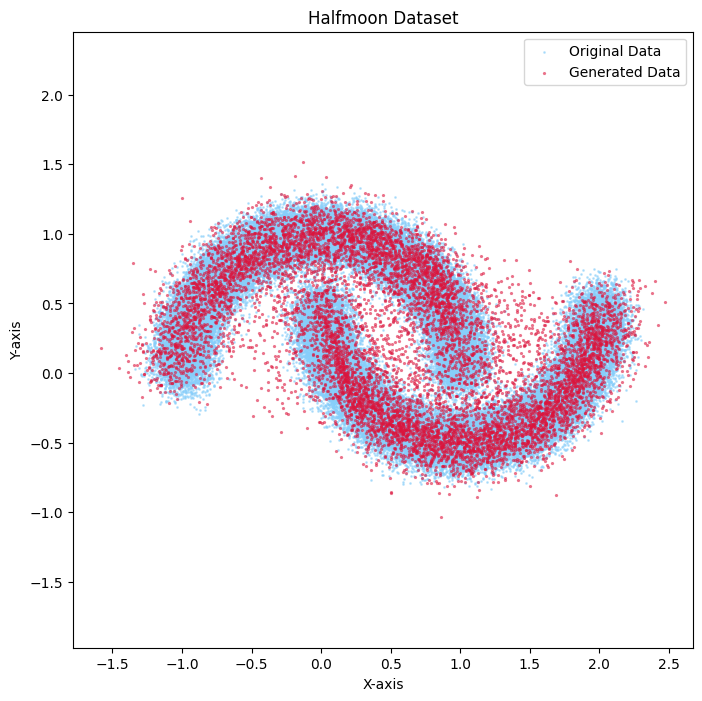

In [54]:
Xgen_halfmoon, Xgen_hist_halfmoon,_, _, samples_halfmoon = sample_ddpm(halfmoon_data_model, 10000, 2)
Xgen_halfmoon = Xgen_halfmoon.cpu()

plt.figure(figsize=(8, 8))
plt.scatter(half_moon_data[:, 0], half_moon_data[:, 1], s=1, c="lightskyblue", alpha=0.5, label="Original Data")
plt.scatter(Xgen_halfmoon[:, 0], Xgen_halfmoon[:, 1], s=5, c="crimson", marker="1", alpha=0.6, label="Generated Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Halfmoon Dataset")
plt.axis("equal")
plt.legend()
plt.show()

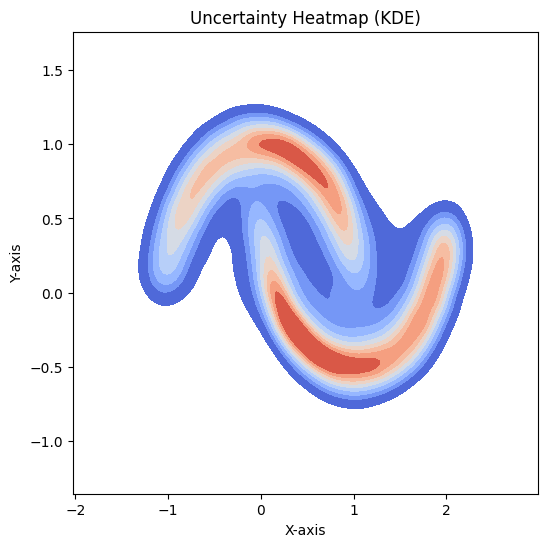

In [55]:
import seaborn as sns

plt.figure(figsize=(6, 6))

all_x = samples_halfmoon[:, :, 0].flatten()
all_y = samples_halfmoon[:, :, 1].flatten()


sns.kdeplot(x=all_x, y=all_y, cmap="coolwarm", fill=True)

plt.title("Uncertainty Heatmap (KDE)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()